# Setup notebook

In [1]:
import os
import sys
from collections import namedtuple

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import statsmodels.api as sm
import utide
from joblib import Parallel, delayed
from matplotlib import dates as mdates
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression

sys.path.append("..")
from src import definitions as defs
from src import features, models

%load_ext autoreload
%autoreload 2
%matplotlib widget
%config Completer.use_jedi = False

In [4]:
wdir = defs.ROOT / "data"

In [214]:
data = pd.read_csv(wdir / "interim" / "sutarkhali_ext.csv", index_col="datetime", parse_dates=True, infer_datetime_format=True).rename(columns={"elevation": "obs"})

freq = data.index[1] - data.index[0]
data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq=freq, name="datetime"))

In [221]:
data["mean_roll"] = data.obs.rolling(window=pd.Timedelta("365D"), center=True).mean()
data["med_roll"] = data.obs.rolling(window=pd.Timedelta("30D"), center=True).mean()

In [226]:
nulls = data.loc[data.obs.isnull()]
starts = nulls.loc[nulls.index - nulls.index.to_series().shift(1) != pd.Timedelta("10T")]
ends = nulls.loc[nulls.index.to_series().shift(-1) - nulls.index != pd.Timedelta("10T")]
gaps = starts.index.to_frame(name="start").reset_index(drop=True)
gaps["end"] = ends.index
gaps["length"] = gaps.end - gaps.start

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
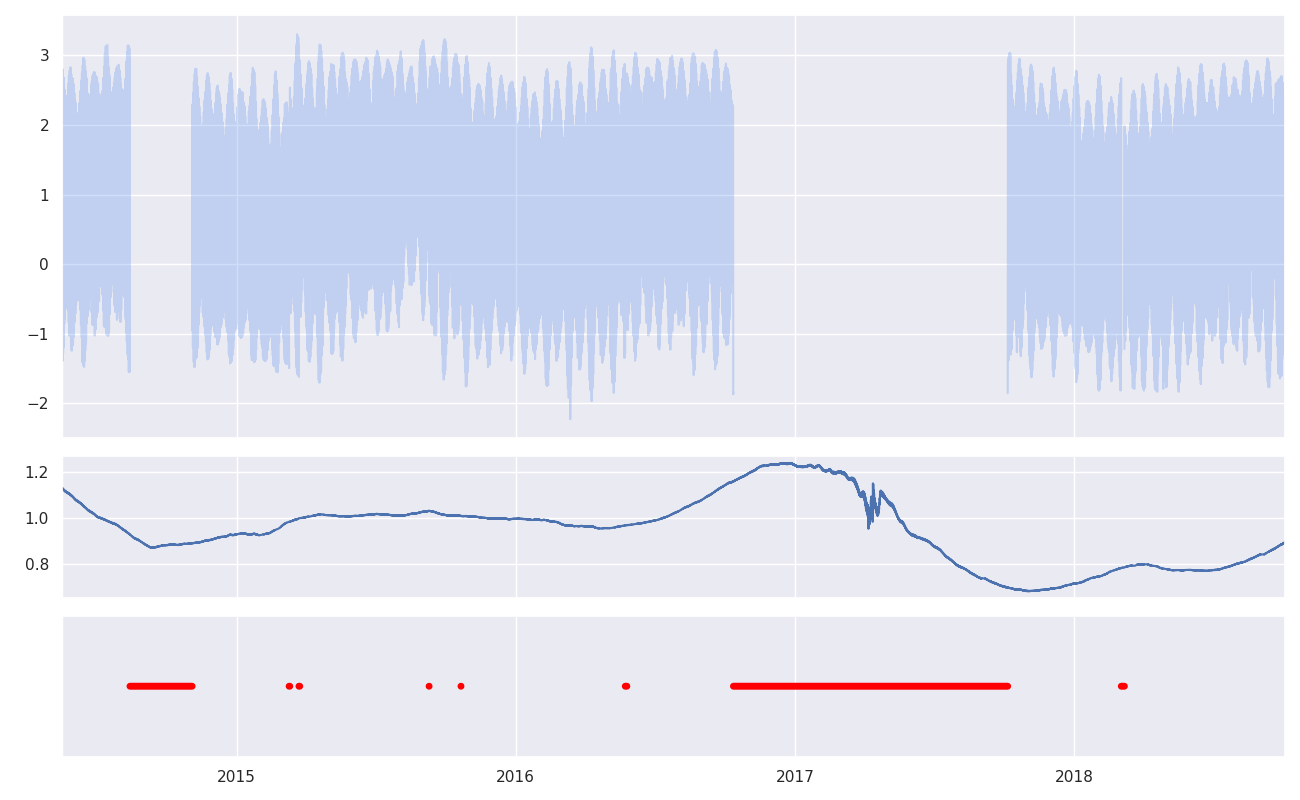

In [222]:
fig = plt.figure(figsize=(13, 8))
axs = fig.subplots(nrows=3, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})

pdata = data.iloc[::6]

pdata.obs.plot(kind="line", ax=axs[0], color="cornflowerblue", alpha=0.3)
pdata.mean_roll.plot(kind="line", ax=axs[1])
data.obs.isnull().replace({True: 0, False: np.nan}).plot(kind="line", ax=axs[2], color="red", lw=5)

axs[2].set_xlim(pdata.index[0], pdata.index[-1])
axs[2].yaxis.set_visible(False)
axs[2].set_xlabel("")
fig.tight_layout()

In [252]:
lat = 22.49984514299519
start = "2014-11-03 17:10:00"
end = "2016-10-11 21:30:00"
elev = data.loc[start:].obs.values
time = mdates.date2num((data.loc[start:].index - pd.Timedelta("6 hours")).to_pydatetime())

coef = utide.solve(t=time, u=elev, lat=lat, conf_int="MC", method="ols", trend=False, nodal=True, constit="auto", verbose=False)
data["pred"] = utide.reconstruct(t=mdates.date2num((data.index - pd.Timedelta("6 hours")).to_pydatetime()), coef=coef, verbose=False).h
data["res"] = data.obs - data.pred

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
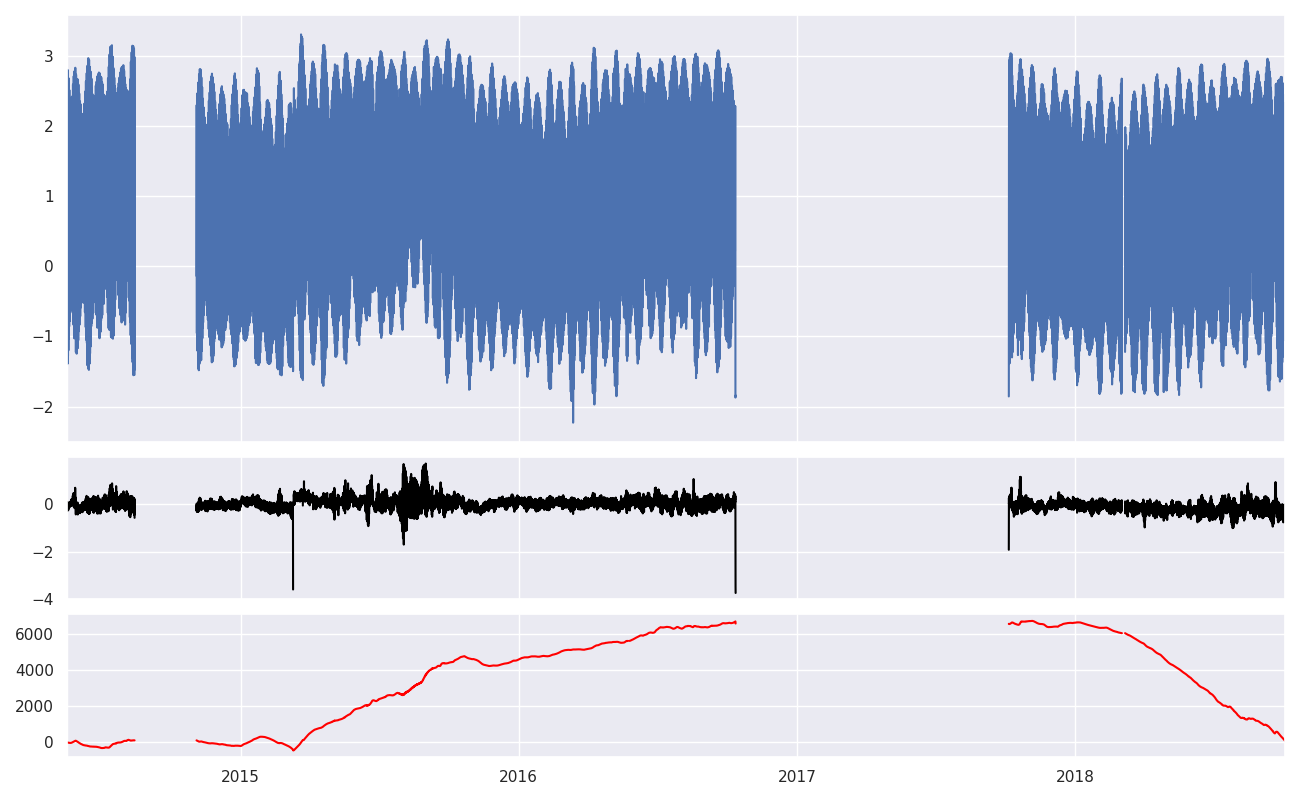

In [253]:
fig = plt.figure(figsize=(13, 8))
axs = fig.subplots(nrows=3, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})

data.iloc[::6].obs.plot(kind="line", ax=axs[0])
data.iloc[::6].res.plot(kind="line", ax=axs[1], color="black")
data.res.cumsum().iloc[::6].plot(kind="line", ax=axs[2], color="red")

axs[2].set_xlim(pdata.index[0], pdata.index[-1])
axs[2].set_xlabel("")
fig.tight_layout()

In [396]:
index = pd.date_range(start="2020", end="2039", freq="1H", closed="left", name="datetime")
vals = utide.reconstruct(t=mdates.date2num((index - pd.Timedelta("6 hours")).to_pydatetime()), coef=coef, verbose=False).h

data = pd.DataFrame(data={"elevation": vals}, index=index)

In [397]:
data[["high", "low"]] = False
distance = pd.Timedelta("1H") / data.index.freq * 8

hi = find_peaks(x=data.elevation.values, distance=distance)[0]
lo = find_peaks(x=data.elevation.values * -1, distance=distance)[0]

data.loc[data.iloc[hi].index, "high"] = True
data.loc[data.iloc[lo].index, "low"] = True

In [398]:
data["high_roll"] = data.loc[data.high == True].elevation.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=data.index).interpolate(method="time", limit_direction="both")
data["low_roll"] = data.loc[data.low == True].elevation.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=data.index).interpolate(method="time", limit_direction="both")
data["amp_roll"] = data.high_roll - data.low_roll

In [399]:
window = pd.Timedelta("10 hour")
exog = (data.index - data.index[0]).total_seconds().astype(int).values
frac = window / pd.Timedelta(freq) / len(data)
delta = window * 500 / pd.Timedelta(freq)
endogs = (data.high_roll.values, data.low_roll.values)
high_smooth, low_smooth = Parallel(n_jobs=2, max_nbytes=None)(delayed(sm.nonparametric.lowess)(endog=endog, exog=exog, frac=frac, delta=delta, is_sorted=True) for endog in endogs)

In [400]:
data.loc[pd.TimedeltaIndex(list(zip(*high_smooth))[0], unit="s") + data.index[0], "high_smooth"] = list(zip(*high_smooth))[1]
data.loc[pd.TimedeltaIndex(list(zip(*low_smooth))[0], unit="s") + data.index[0], "low_smooth"] = list(zip(*low_smooth))[1]
data["amp_smooth"] = data.high_smooth - data.low_smooth

In [401]:
data[["spring", "neap"]] = False
distance = pd.Timedelta("1H") / data.index.freq * 24 * 11 # search distance in hours
hi = find_peaks(x=data.amp_smooth.values, distance=distance, height=3.0)[0]
lo = find_peaks(x=data.amp_smooth.values * -1, distance=distance, height=-3.0)[0]
data.loc[data.iloc[hi].index, "spring"] = True
data.loc[data.iloc[lo].index, "neap"] = True

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
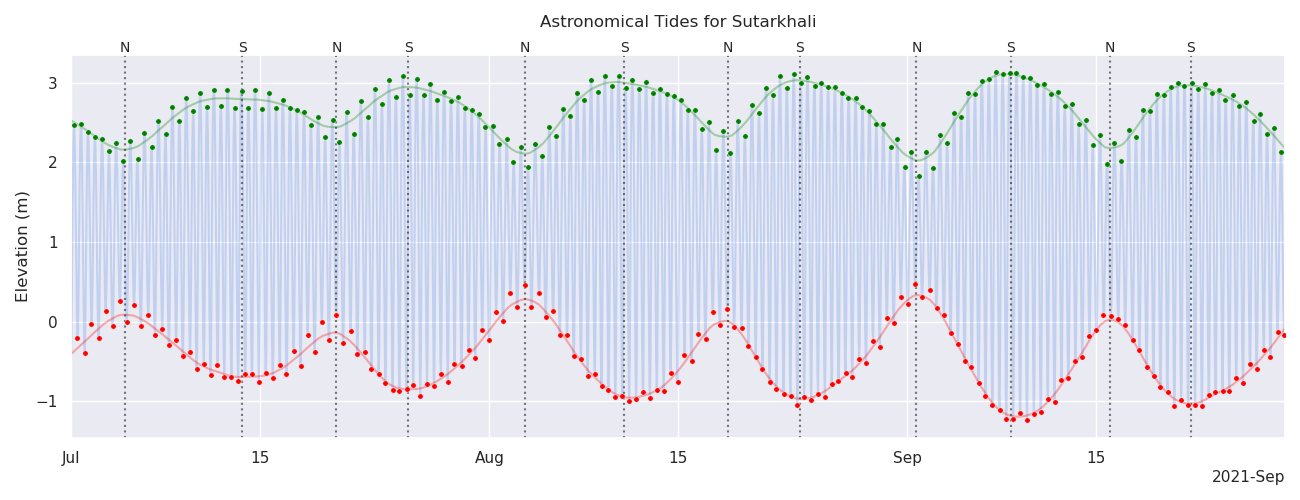

In [402]:
start = pd.to_datetime("2021-07-01")
end = start + pd.Timedelta("90D")

pdata = data.loc[start:end].reset_index()

fig = plt.figure(figsize=(13, 5))
ax = fig.subplots()

sns.lineplot(data=pdata, x="datetime", y="elevation", color="cornflowerblue", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="high_smooth", color="green", alpha=0.3, ax=ax)
sns.lineplot(data=pdata, x="datetime", y="low_smooth", color="red", alpha=0.3, ax=ax)
# sns.lineplot(data=pdata, x="datetime", y="amp_smooth", color="black", alpha=0.3, ax=ax)

sns.scatterplot(data=pdata.loc[pdata.high == True], x="datetime", y="elevation", color="green", s=15, ax=ax, zorder=15)
sns.scatterplot(data=pdata.loc[pdata.low == True], x="datetime", y="elevation", color="red", s=15, ax=ax, zorder=15)

for loc in pdata.loc[pdata.spring == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="S", rotation=0, ha="center", va="bottom")

for loc in pdata.loc[pdata.neap == True].datetime:
    ax.axvline(x=loc, color="black", linestyle="dotted", alpha=0.5)
    ax.text(x=loc, y=ax.get_ylim()[1], s="N", rotation=0, ha="center", va="bottom")

title = "Astronomical Tides for Sutarkhali"
xlabel = ""
ylabel = "Elevation (m)"

locator = locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

ax.xaxis.set(major_locator=locator, major_formatter=formatter)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.set_title(label=title, pad=20)
ax.set_xlim(start, end)
fig.tight_layout()

In [403]:
springs = data.loc[data.spring == True].apply(
    lambda x: pd.Series(data=(
        data.loc[data.high == True].elevation.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean(),
        data.loc[data.low == True].elevation.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean()),
        index=("high", "low")),
        axis=1)

neaps = data.loc[data.neap == True].apply(
    lambda x: pd.Series(data=(
        data.loc[data.high == True].elevation.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean(),
        data.loc[data.low == True].elevation.loc[x.name-pd.Timedelta("13.5 hours"):x.name+pd.Timedelta("13.5 hours")].mean()),
        index=("high", "low")),
        axis=1)

In [404]:
springs_yearly = springs.groupby(by=pd.Grouper(freq="AS")).mean().set_index(springs.index.year.unique())

In [412]:
data["mean_roll"] = data.elevation.rolling(window=pd.Timedelta("14 days"), center=True).mean()
beta_sh = 12e-3
beta_sl = 4e-3

In [413]:
data["elev_amp"] = np.nan
data.loc[data.elevation > data.mean_roll, "elev_amp"] = data.loc[data.elevation > data.mean_roll].apply(
    lambda row: row.elevation + row.elevation / springs_yearly.high.loc[row.name.year] * beta_sh * (row.name - data.index[0]) / pd.Timedelta("365.25 days"),
    axis=1)

data.loc[data.elevation < data.mean_roll, "elev_amp"] = data.loc[data.elevation < data.mean_roll].apply(
    lambda row: row.elevation - row.elevation / springs_yearly.low.loc[row.name.year] * beta_sl * (row.name - data.index[0]) / pd.Timedelta("365.25 days"),
    axis=1)

In [414]:
daily = data.elev_amp.groupby(by=pd.Grouper(freq="D")).agg(["max", "min"])
monthly = daily.groupby(by=pd.Grouper(freq="MS")).agg("mean").rename(columns={"max": "MHW", "min": "MLW"})

In [415]:
def lm_tides(data, ref_date=None, time_unit="365.25 days"):
    from collections import namedtuple

    if ref_date == None:
        ref_date = data.index[0]

    LM = namedtuple("LM", "coef, intercept , lin_ts, ts")

    x = ((data.index - ref_date) / pd.Timedelta(time_unit)).values.reshape(-1, 1)
    y = data.values.reshape(-1, 1)
    lm = LinearRegression().fit(x, y)

    lin_ts = pd.Series(data=lm.predict(x[[0, -1]]).flatten(), index=data.iloc[[0, -1]].index)

    return(LM(lm.coef_[0,0], lm.intercept_[0], lin_ts, data))

In [416]:
lms = monthly.apply(func=lm_tides, result_type="reduce")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
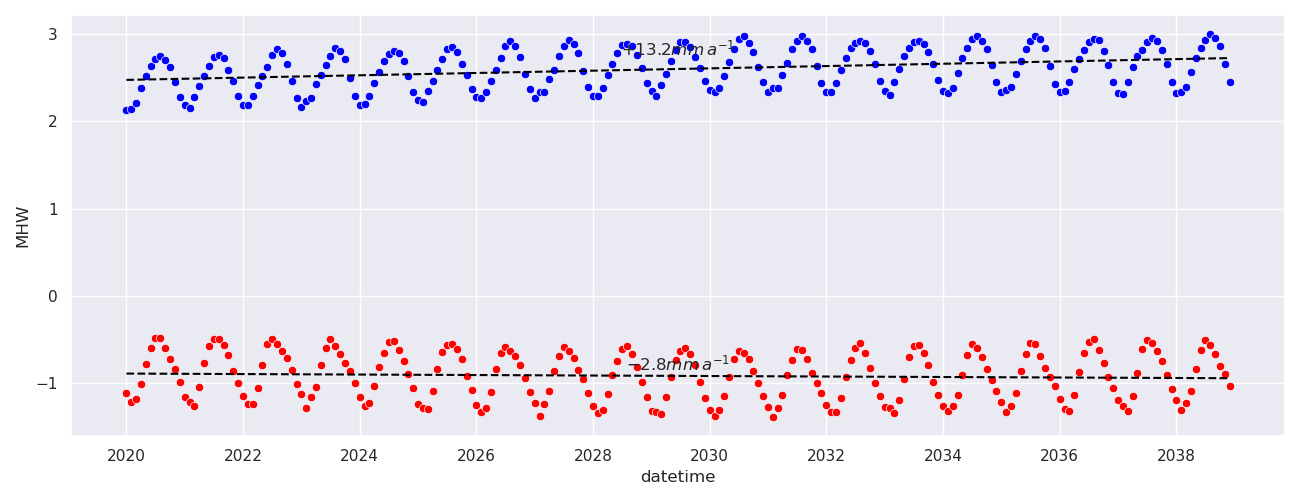

In [417]:
fig = plt.figure(figsize=(13, 5))
ax = fig.subplots()

sns.scatterplot(data=lms.MHW.ts, color="blue", ax=ax)
sns.lineplot(data=lms.MHW.lin_ts, ls="--", color="black", ax=ax)
ax.text(x=lms.MHW.lin_ts.index.mean(), y=lms.MHW.lin_ts.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(lms.MHW.coef * 1000), fontsize="large", fontweight="bold")

sns.scatterplot(data=lms.MLW.ts, color="red", ax=ax)
sns.lineplot(data=lms.MLW.lin_ts, ls="--", color="black", ax=ax)
ax.text(x=lms.MLW.lin_ts.index.mean(), y=lms.MLW.lin_ts.max(), ha="center", va="bottom", zorder=30, s="${:+.1f} mm \, a^{{-1}}$".format(lms.MLW.coef * 1000), fontsize="large", fontweight="bold")

fig.tight_layout()